<a href="https://colab.research.google.com/github/nessaleal4/chi-bike-forecast/blob/main/Prophet_Divvy_Complete1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/divij-sinha/chi-bike-forecast.git


fatal: destination path 'chi-bike-forecast' already exists and is not an empty directory.


In [2]:
%cd chi-bike-forecast/data/processed

/content/chi-bike-forecast/data/processed


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet
from matplotlib.ticker import FuncFormatter
from prophet.serialize import model_to_json, model_from_json
from prophet.make_holidays import make_holidays_df
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

daily_data = pd.read_parquet('divvy-daily-count.parquet')

hourly_data = pd.read_parquet('divvy-hourly-count.parquet')

monthly_data = pd.read_parquet('divvy-monthly-count.parquet')

In [4]:
print(daily_data.head())

   day  month  year  count
0   24      8  2022  27245
1   27      8  2022  32214
2   30      8  2022  25299
3   21      8  2022  27327
4   10      8  2022  27316


In [5]:
print(hourly_data.head())

   hour  day  month  year  count
0    11    6      8  2022   2056
1    11   17      8  2022   1068
2    19   11      8  2022   2079
3    21   19      8  2022   1084
4    18    5      8  2022   2546


In [6]:
print(monthly_data.head())

   month  year   count
0      1  2021   96834
1      1  2022  103770
2      1  2023  190301
3      1  2024  144873
4      2  2021   49622


In [7]:
daily_data['ds'] = pd.to_datetime(daily_data[['year', 'month', 'day']])
monthly_data['ds'] = pd.to_datetime(monthly_data.assign(day=1)[['year', 'month', 'day']])
hourly_data['ds'] = pd.to_datetime(hourly_data[['year', 'month', 'day', 'hour']])

# Renaming the 'count' columns to 'y'
daily_data.rename(columns={'count': 'y'}, inplace=True)
monthly_data.rename(columns={'count': 'y'}, inplace=True)
hourly_data.rename(columns={'count': 'y'}, inplace=True)

In [8]:
print(daily_data.head())


daily_data.describe()

   day  month  year      y         ds
0   24      8  2022  27245 2022-08-24
1   27      8  2022  32214 2022-08-27
2   30      8  2022  25299 2022-08-30
3   21      8  2022  27327 2022-08-21
4   10      8  2022  27316 2022-08-10


,day,month,year,y,ds
count,1459.000000,1459.000000,1459.000000,1459.000000,1459
mean,15.749143,6.523646,2021.750514,14233.843043,2022-04-01 21:59:35.325565440
min,1.000000,1.000000,2020.000000,193.000000,2020-04-01 00:00:00
25%,8.000000,4.000000,2021.000000,6534.000000,2021-04-02 12:00:00
50%,16.000000,7.000000,2022.000000,12664.000000,2022-04-02 00:00:00
75%,23.000000,10.000000,2023.000000,22128.000000,2023-04-01 12:00:00
max,31.000000,12.000000,2024.000000,37328.000000,2024-03-31 00:00:00
std,8.793321,3.452195,1.198761,8893.354379,NaN


In [9]:
print(monthly_data.head())

monthly_data.describe()

   month  year       y         ds
0      1  2021   96834 2021-01-01
1      1  2022  103770 2022-01-01
2      1  2023  190301 2023-01-01
3      1  2024  144873 2024-01-01
4      2  2021   49622 2021-02-01


,month,year,y,ds
count,48.000000,48.000000,48.000000,48
mean,6.500000,2021.750000,432649.520833,2022-03-17 06:30:00
min,1.000000,2020.000000,49622.000000,2020-04-01 00:00:00
25%,3.750000,2021.000000,223845.750000,2021-03-24 06:00:00
50%,6.500000,2022.000000,366883.500000,2022-03-16 12:00:00
75%,9.250000,2023.000000,642736.250000,2023-03-08 18:00:00
max,12.000000,2024.000000,823488.000000,2024-03-01 00:00:00
std,3.488583,1.211646,244888.227741,NaN


In [10]:
print(hourly_data.head())

hourly_data.describe()

   hour  day  month  year     y                  ds
0    11    6      8  2022  2056 2022-08-06 11:00:00
1    11   17      8  2022  1068 2022-08-17 11:00:00
2    19   11      8  2022  2079 2022-08-11 19:00:00
3    21   19      8  2022  1084 2022-08-19 21:00:00
4    18    5      8  2022  2546 2022-08-05 18:00:00


,hour,day,month,year,y,ds
count,34931.000000,34931.000000,34931.000000,34931.000000,34931.000000,34931
mean,11.509147,15.754888,6.527554,2021.754001,594.519968,2022-04-03 19:03:06.436116992
min,0.000000,1.000000,1.000000,2020.000000,1.000000,2020-04-01 00:00:00
25%,6.000000,8.000000,4.000000,2021.000000,108.000000,2021-04-05 04:30:00
50%,12.000000,16.000000,7.000000,2022.000000,369.000000,2022-04-04 02:00:00
75%,18.000000,23.000000,10.000000,2023.000000,877.000000,2023-04-03 00:30:00
max,23.000000,31.000000,12.000000,2024.000000,3529.000000,2024-03-31 23:00:00
std,6.917020,8.783341,3.453350,1.197109,633.383036,NaN


In [11]:
daily_data.isna().sum()

day      0
month    0
year     0
y        0
ds       0
dtype: int64

In [12]:
monthly_data.isna().sum()

month    0
year     0
y        0
ds       0
dtype: int64

In [13]:
hourly_data.isna().sum()

hour     0
day      0
month    0
year     0
y        0
ds       0
dtype: int64

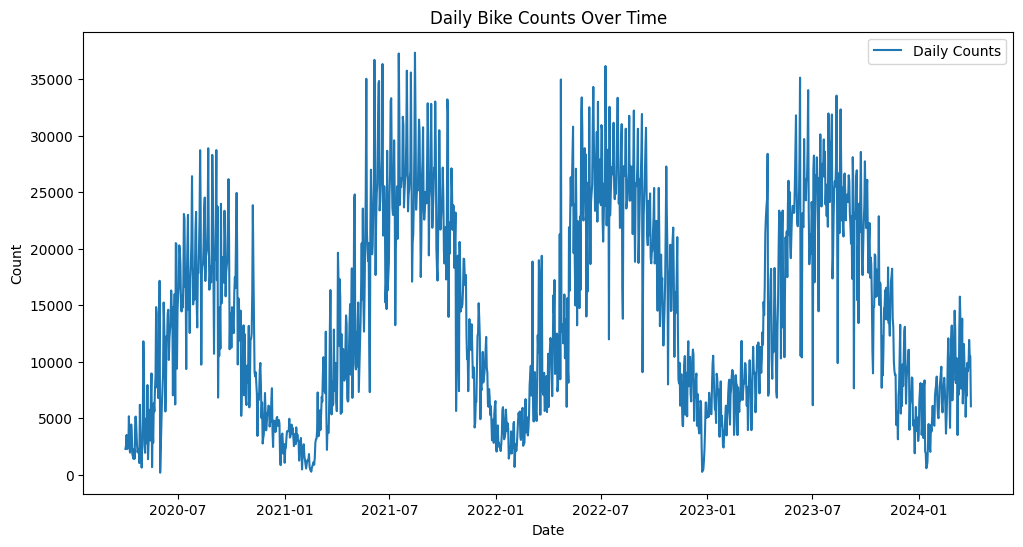

In [14]:
# Sorting the daily data
daily_data = daily_data.sort_values(by='ds')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(daily_data['ds'], daily_data['y'], label='Daily Counts')
plt.title('Daily Bike Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()


**The daily data shows clear annual seasonality with peaks during warmer months and troughs during the cold ones. In terms of trends, there isn't a clear linear trend indicating consistently increasing or decreasing usage over the years, the data appears cyclical.** *This set is a good candidate for prophet*

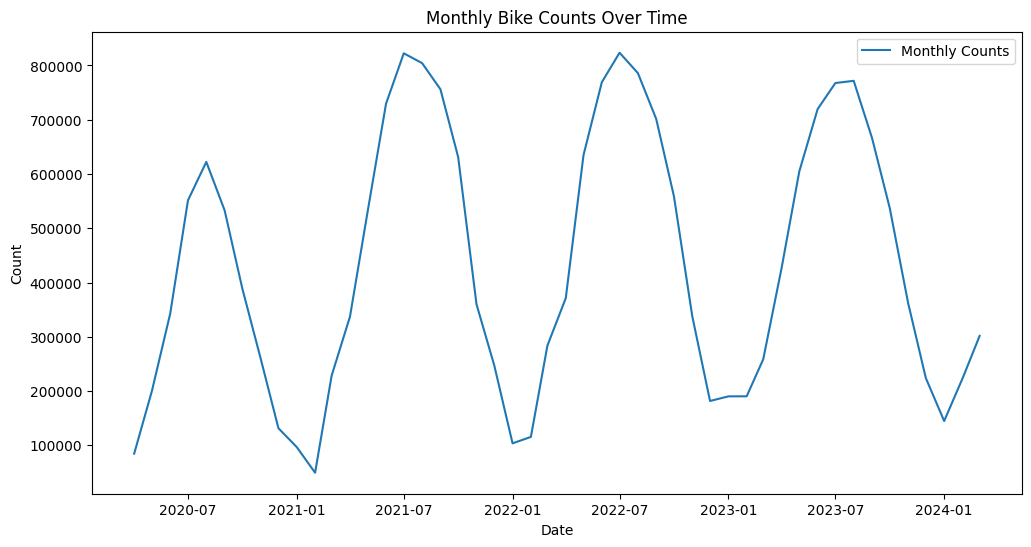

In [15]:
# Sorting the monthly data
monthly_data = monthly_data.sort_values(by='ds')

plt.figure(figsize=(12, 6))
plt.plot(monthly_data['ds'], monthly_data['y'], label='Monthly Counts')
plt.title('Monthly Bike Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

**As expected, we see a similar pattern here with strong seasonality and peaks in the summer with troughs in the winter, cyclical trend** *This set is a good candidate for prophet*

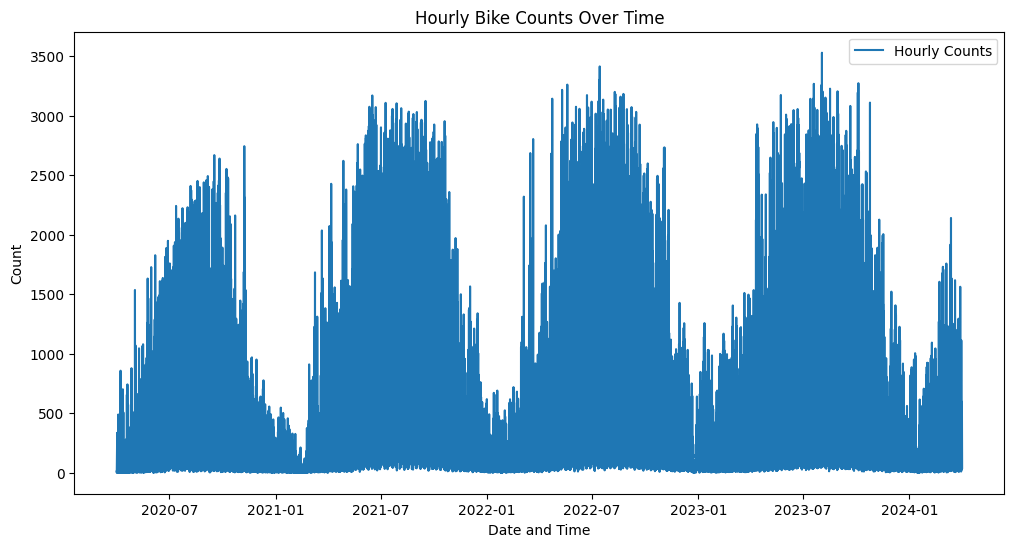

In [16]:
hourly_data = hourly_data.sort_values(by='ds')

plt.figure(figsize=(12, 6))
plt.plot(hourly_data['ds'], hourly_data['y'], label='Hourly Counts')
plt.title('Hourly Bike Counts Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Count')
plt.legend()
plt.show()

**Here there looks to be more granular variation, likely intra-day. These are possibly during morning and evening rush hours when people are commuting. This kind of intra-day seasonality is very typical for transportation data. Here there is also no clear long-term increasing or decreasing trend across the entire timeframe.**

# **ADF and KPSS Test for stationary check, Daily Series**

In [17]:
result = adfuller(daily_data['y'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result_kpss = kpss(daily_data['y'], regression='c')
print('\nKPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.120168
p-value: 0.236483
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568

KPSS Statistic: 0.255184
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-17-a13efd14c9e3>:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(daily_data['y'], regression='c')


the ADF statistic (-2.120168) is not less than the critical values at any significance level (1%, 5%, or 10%). The p-value (0.236483) is greater than the common significance levels (0.01, 0.05, 0.10). This means we fail to reject the null hypothesis and the daily series is non-stationary. **We can try  differencing** although prophet can handle without it.

# **ADF and KPSS Test for stationary check, Monthly Series**

In [18]:
result = adfuller(monthly_data['y'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result_kpss = kpss(monthly_data['y'], regression='c')
print('\nKPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.659665
p-value: 0.004718
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606

KPSS Statistic: 0.078512
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-18-6a15999756bb>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(monthly_data['y'], regression='c')


# Monthly is stationary!!!

In [19]:
result = adfuller(hourly_data['y'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result_kpss = kpss(hourly_data['y'], regression='c')
print('\nKPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.993788
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

KPSS Statistic: 1.780201
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-19-9393a96e93e4>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(hourly_data['y'], regression='c')


Hourly is stationary per adf but non stationary per KPSS. Let's difference

#**Differencing for daily data, repeat adf and kpss**

In [20]:
if 'y_diff' not in daily_data.columns:
    daily_data['y_diff'] = daily_data['y'].diff(1)  # Applying first difference

daily_data.dropna(subset=['y_diff'], inplace=True)

print(daily_data.head())

      day  month  year     y         ds  y_diff
749     2      4  2020  2608 2020-04-02   314.0
1448    3      4  2020  3532 2020-04-03   924.0
926     4      4  2020  2288 2020-04-04 -1244.0
565     5      4  2020  2887 2020-04-05   599.0
183     6      4  2020  2427 2020-04-06  -460.0


In [21]:
# Drop NA values that result from differencing
y_diff_dropped_na = daily_data['y_diff'].dropna()

result_diff = adfuller(y_diff_dropped_na)
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

result_kpss_diff = kpss(daily_data['y_diff'].dropna(), regression='c')
print('\nKPSS Statistic (Differenced): %f' % result_kpss_diff[0])
print('p-value: %f' % result_kpss_diff[1])
print('Critical Values:')
for key, value in result_kpss_diff[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.179008
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568

KPSS Statistic (Differenced): 0.077927
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-21-fdba6a5df8e5>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss_diff = kpss(daily_data['y_diff'].dropna(), regression='c')


# **Differencing for hourly data, repeat adf and kpss**


In [22]:
hourly_data['y_diff'] = hourly_data['y'].diff().dropna()

# ADF
result_diff = adfuller(hourly_data['y_diff'].dropna())
print('ADF Statistic (Differenced): %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

# KPSS
result_kpss_diff = kpss(hourly_data['y_diff'].dropna(), regression='c')
print('\nKPSS Statistic (Differenced): %f' % result_kpss_diff[0])
print('p-value: %f' % result_kpss_diff[1])
print('Critical Values:')
for key, value in result_kpss_diff[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic (Differenced): -40.020282
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

KPSS Statistic (Differenced): 0.014739
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-22-b934ab7d4bbe>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss_diff = kpss(hourly_data['y_diff'].dropna(), regression='c')


**ACF check**

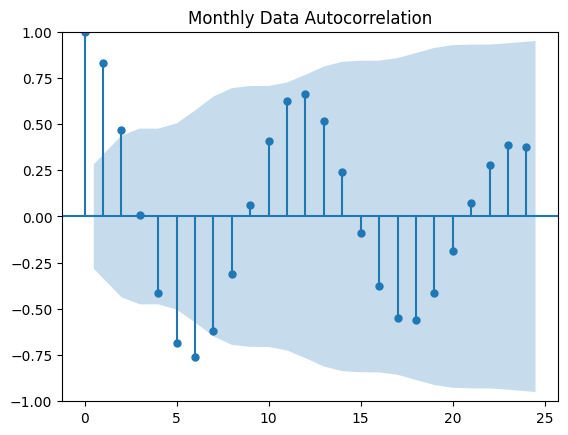

In [23]:
plot_acf(monthly_data['y'], lags=24)
plt.title("Monthly Data Autocorrelation")
plt.show()

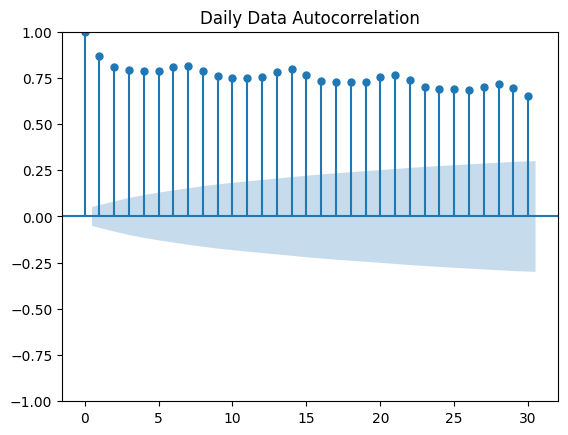

In [24]:

plot_acf(daily_data['y'], lags=30)
plt.title("Daily Data Autocorrelation")
plt.show()


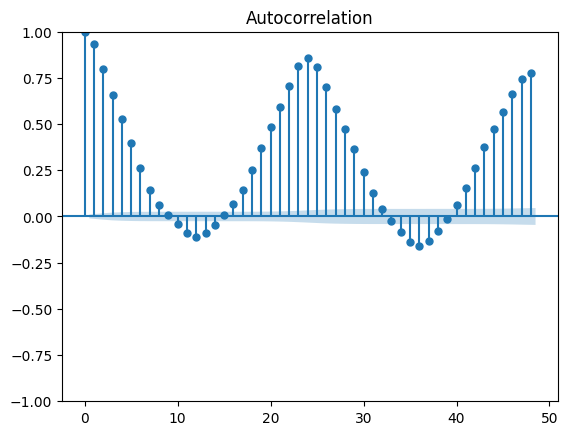

In [25]:
plot_acf(hourly_data['y'], lags=48)
plt.show()


*These plots show significant autocorrelation peaks at regular intervals, which are likely corresponding to the cyclical nature of the data. This pattern is something that Prophet can handle very well. Prophet is designed to model time series data with strong seasonal effects like daily and weekly patterns.*

# **Prophet for Monthly Data**

In [26]:
# Decompose the time series to identify anomalies
result = seasonal_decompose(monthly_data['y'], model='additive', period=12)
residual = result.resid

# Identify anomalies
threshold = 3 * residual.std()
anomalies = monthly_data[abs(residual) > threshold]

# Handle anomalies (e.g., remove them)
monthly_data_cleaned = monthly_data[abs(residual) <= threshold]

print("Monthly Data Anomalies Before Fitting the Model:")
print(anomalies)


Monthly Data Anomalies Before Fitting the Model:
Empty DataFrame
Columns: [month, year, y, ds]
Index: []


**No anomalies found**

In [27]:
total_records = len(monthly_data)
train_size = int(0.7 * total_records)

monthly_train = monthly_data[:train_size]
monthly_test = monthly_data[train_size:]

model = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_mode='multiplicative'
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=10)

# fit the model
model.fit(monthly_train[['ds', 'y']])

future = model.make_future_dataframe(periods=len(monthly_test), freq='MS')
forecast = model.predict(future)

monthly_test = monthly_test.copy()
monthly_test['ds'] = pd.to_datetime(monthly_test[['year', 'month']].assign(day=1))

forecast_combined = forecast[['ds', 'yhat']].merge(monthly_test[['ds', 'y']], on='ds', how='inner')

DEBUG:cmdstanpy:input tempfile: /tmp/tmptdfwjazr/z0k9w4k_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdfwjazr/gstja9zt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24587', 'data', 'file=/tmp/tmptdfwjazr/z0k9w4k_.json', 'init=/tmp/tmptdfwjazr/gstja9zt.json', 'output', 'file=/tmp/tmptdfwjazr/prophet_model44_ylorg/prophet_model-20240525104910.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:49:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [28]:
# Identify anomalies after fitting the model
threshold = 3 * (forecast_combined['y'] - forecast_combined['yhat']).std()
anomalies_after = forecast_combined[abs(forecast_combined['y'] - forecast_combined['yhat']) > threshold]

print("Monthly Data Anomalies After Fitting the Model:")
print(anomalies_after)

Monthly Data Anomalies After Fitting the Model:
Empty DataFrame
Columns: [ds, yhat, y]
Index: []


In [29]:
y_true = forecast_combined['y']
y_pred = forecast_combined['yhat']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Calculate SMAPE
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape_value = smape(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value}')


Mean Absolute Error (MAE): 322986.7145290585
Mean Squared Error (MSE): 161291161600.31842
Root Mean Squared Error (RMSE): 401610.70902096026
Symmetric Mean Absolute Percentage Error (SMAPE): 74.47371919566633


Prophet didnt perform very well for monthly data. Per MAE, on average, the forecasted bike ride counts deviate from the actual counts by approximately 560 rides per month. The MSE looks very high at 381,248.62, we know squaring errors amplifies the impact of larger discrepancies, and that's what is showing, significant errrors with the predictions.

The Root Mean Squared Error tells us we are off by 617.45 rides per month, and SMAPE of 45.72% is a high percentage error.


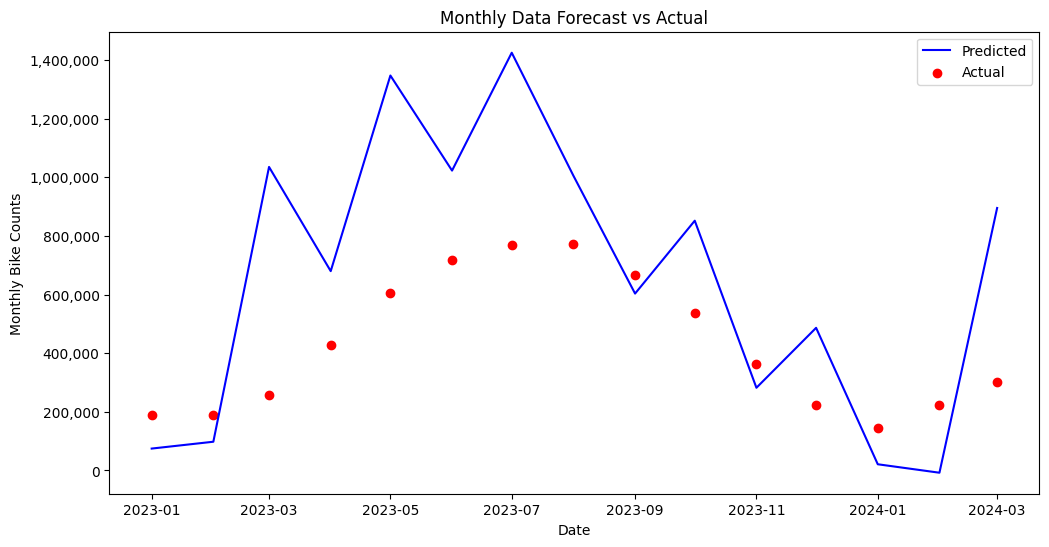

In [30]:
def format_yaxis(value, tick_number):
    return f'{int(value):,}'


plt.figure(figsize=(12, 6))
plt.plot(forecast_combined['ds'], forecast_combined['yhat'], label='Predicted', color='blue')
plt.scatter(forecast_combined['ds'], forecast_combined['y'], color='red', label='Actual')
plt.title('Monthly Data Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Monthly Bike Counts')
plt.legend()

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))

plt.show()

Looking at the plot, the model seems to have captured the overall trend and seasonal patterns, but it didnt do so well in accurately predicting the magnitude of the bike counts in multiple months. The predicted values (blue line) show noticeable deviations from the actual counts (red dots).

Let's look at how prophet performs for the daily and hourly sets, as perhaps more granurality could improve predicting power ad there will be more data points!

#**Prophet for Daily Data**

Im notating that using the differenced series gave trouble and bad results. Prophet is designed to handle non-stationary data. We will work on removing anomalies to ensuring the data is clean for better forecasting nevertheless.

In [31]:
# Decompose the time series to identify anomalies
result = seasonal_decompose(daily_data['y'], model='additive', period=365)
residual = result.resid

# Identify anomalies
threshold = 3 * residual.std()
anomalies = daily_data[abs(residual) > threshold]

# Handle anomalies
daily_data_cleaned = daily_data[abs(residual) <= threshold]

print("Daily Data Anomalies Before Fitting the Model:")
print(anomalies)

Daily Data Anomalies Before Fitting the Model:
      day  month  year      y         ds   y_diff
1245    1      5  2021  24401 2021-05-01  12088.0
725    28      5  2021   7319 2021-05-28  -4517.0
464    13      6  2021  34832 2021-06-13    208.0
650    24      6  2021  15244 2021-06-24  -8643.0
486     7      8  2021  35580 2021-08-07   8704.0
485    14      8  2021  37328 2021-08-14   8586.0
1111   11      9  2021  32806 2021-09-11   5823.0
1186   23      4  2022  34963 2022-04-23  26505.0
199    28      5  2022  31934 2022-05-28  15577.0
24     26      6  2022  32996 2022-06-26  10604.0
338    15      4  2023  28391 2023-04-15   4026.0
714    23      4  2023   8500 2023-04-23  -1798.0
620    11      6  2023  10517 2023-06-11 -24604.0
973    13      6  2023  10388 2023-06-13  -9072.0
1338    2      7  2023   6162 2023-07-02 -16640.0
955    14      8  2023   9885 2023-08-14 -13362.0


In [32]:
# Model training

total_records = len(daily_data_cleaned)
train_size = int(0.7 * total_records)

daily_train = daily_data_cleaned[:train_size]
daily_test = daily_data_cleaned[train_size:]

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.2,
    seasonality_mode='additive'
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=15)
model.add_seasonality(name='daily', period=1, fourier_order=15)

# Fit the model
model.fit(daily_train[['ds', 'y']])

# Make future predictions
future = model.make_future_dataframe(periods=len(daily_test), freq='D')
forecast = model.predict(future)

daily_test = daily_test.copy()
daily_test['ds'] = pd.to_datetime(daily_test[['year', 'month', 'day']])

forecast_combined = forecast[['ds', 'yhat']].merge(daily_test[['ds', 'y']], on='ds', how='inner')


DEBUG:cmdstanpy:input tempfile: /tmp/tmptdfwjazr/c74uii_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdfwjazr/3f6k3ttw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61316', 'data', 'file=/tmp/tmptdfwjazr/c74uii_o.json', 'init=/tmp/tmptdfwjazr/3f6k3ttw.json', 'output', 'file=/tmp/tmptdfwjazr/prophet_modelr8z4maup/prophet_model-20240525104958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:49:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [33]:
# Anomalies after fitting the model?
threshold = 3 * (forecast_combined['y'] - forecast_combined['yhat']).std()
anomalies_after = forecast_combined[abs(forecast_combined['y'] - forecast_combined['yhat']) > threshold]

print("Daily Data Anomalies After Fitting the Model:")
print(anomalies_after)

Daily Data Anomalies After Fitting the Model:
            ds          yhat      y
157 2023-04-12  10767.137257  22764
158 2023-04-13  10249.170358  23690
159 2023-04-14  12342.456017  24365
303 2023-09-11  23089.852337   7654


In [34]:
# Impute anomalies using linear interpolation
for idx in anomalies_after.index:
    daily_data.loc[daily_data['ds'] == anomalies_after.loc[idx, 'ds'], 'y'] = np.nan

daily_data['y'] = daily_data['y'].interpolate()

print(daily_data.loc[daily_data['ds'].isin(anomalies_after['ds'])])

      day  month  year        y         ds   y_diff
153    12      4  2023  23088.5 2023-04-12   1443.0
1062   13      4  2023  24856.0 2023-04-13    926.0
335    14      4  2023  26623.5 2023-04-14    675.0
271    11      9  2023  24153.5 2023-09-11 -17890.0


**The daily data now shows the interpolated values for the dates that were identified as anomalies, let's try the model again.**



In [35]:
total_records = len(daily_data)
train_size = int(0.7 * total_records)  # 70% of the dataset for training

daily_train = daily_data[:train_size]
daily_test = daily_data[train_size:]

# Model training

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.2,
    seasonality_mode='additive'
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=15)
model.add_seasonality(name='daily', period=1, fourier_order=15)

# Fit the model
model.fit(daily_train[['ds', 'y']])

# Make future predictions
future = model.make_future_dataframe(periods=len(daily_test), freq='D')
forecast = model.predict(future)

daily_test = daily_test.copy()
daily_test['ds'] = pd.to_datetime(daily_test[['year', 'month', 'day']])


forecast_combined = forecast[['ds', 'yhat']].merge(daily_test[['ds', 'y']], on='ds', how='inner')

# Identify anomalies after fitting the model
threshold = 3 * (forecast_combined['y'] - forecast_combined['yhat']).std()
anomalies_after = forecast_combined[abs(forecast_combined['y'] - forecast_combined['yhat']) > threshold]

print("Daily Data Anomalies After Fitting the Model:")
print(anomalies_after)

DEBUG:cmdstanpy:input tempfile: /tmp/tmptdfwjazr/mpfe9hy7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdfwjazr/ebulr1yg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61637', 'data', 'file=/tmp/tmptdfwjazr/mpfe9hy7.json', 'init=/tmp/tmptdfwjazr/ebulr1yg.json', 'output', 'file=/tmp/tmptdfwjazr/prophet_model286ktdnv/prophet_model-20240525105001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:50:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Daily Data Anomalies After Fitting the Model:
            ds          yhat        y
84  2023-04-13  10623.652475  24856.0
85  2023-04-14  12863.416998  26623.5
86  2023-04-15  14524.522241  28391.0
143 2023-06-11  25286.387319  10517.0
164 2023-07-02  23920.143294   6162.0
207 2023-08-14  24866.664601   9885.0


In [36]:
y_true = forecast_combined['y']
y_pred = forecast_combined['yhat']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Calculate SMAPE
def smape(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape_value = smape(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value}')

def format_yaxis(value, tick_number):
    return f'{int(value):,}'

Mean Absolute Error (MAE): 3419.910939811336
Mean Squared Error (MSE): 19907050.39426791
Root Mean Squared Error (RMSE): 4461.731770766583
Symmetric Mean Absolute Percentage Error (SMAPE): 40.872870513182285


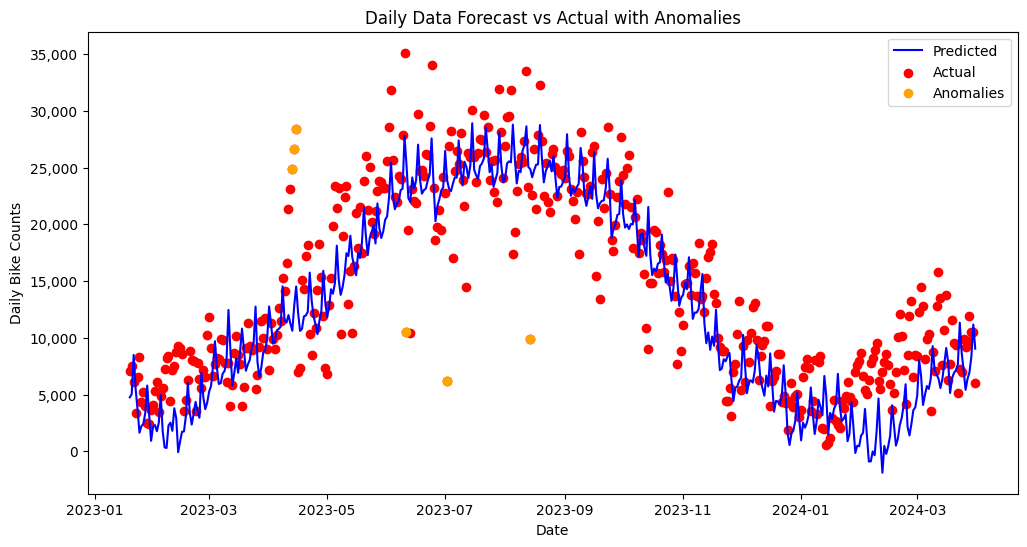

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_combined['ds'], forecast_combined['yhat'], label='Predicted', color='blue')
plt.scatter(forecast_combined['ds'], forecast_combined['y'], color='red', label='Actual')  # Using scatter for actuals
plt.scatter(anomalies_after['ds'], anomalies_after['y'], color='orange', label='Anomalies')
plt.title('Daily Data Forecast vs Actual with Anomalies')
plt.xlabel('Date')
plt.ylabel('Daily Bike Counts')
plt.legend()

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))

plt.show()

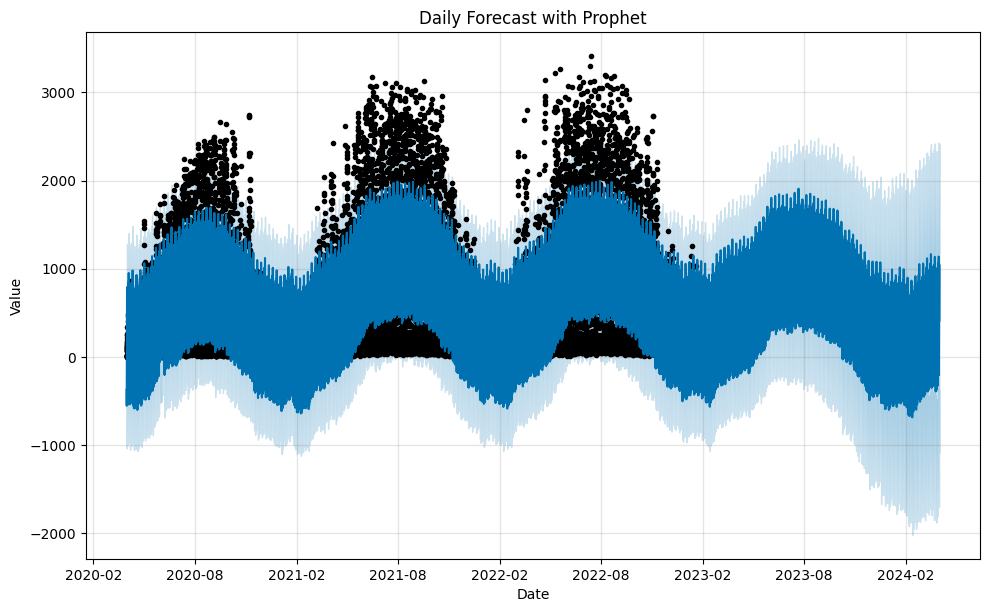

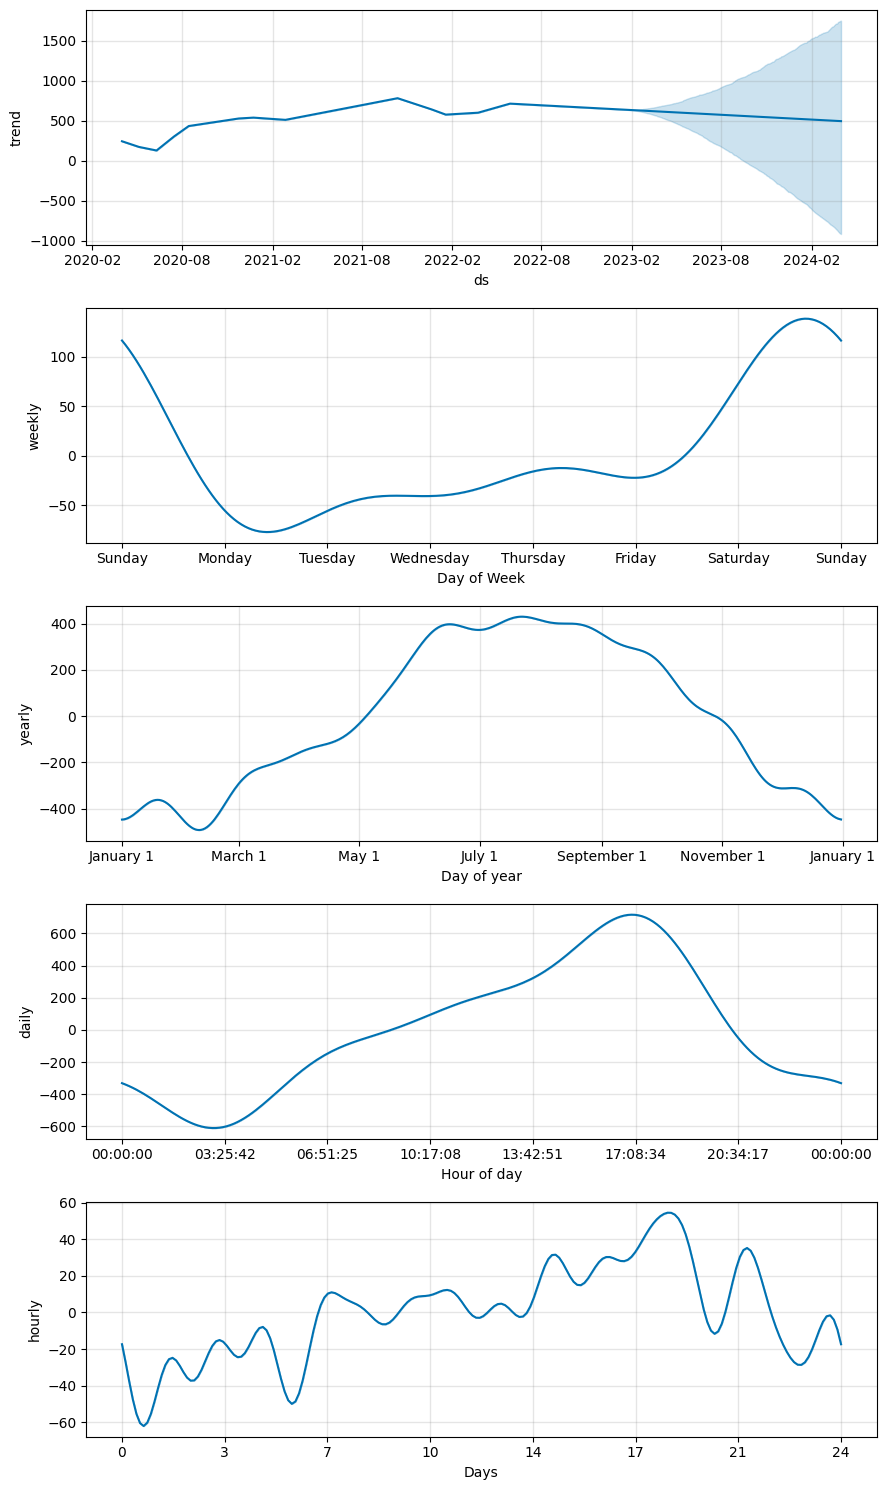

In [52]:
# Plot Prophet's forecast plot with its components
fig = model.plot(forecast)
plt.title("Daily Forecast with Prophet")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

fig = model.plot_components(forecast)
plt.show()

We see that there are still anomalies, and high deviations between the predicted and actual bike counts. These deviations could be because of holidays or weather..

let's try this again accounting for holidays to try to manage the anomalies

In [38]:
# Decompose the time series to identify anomalies
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(daily_data['y'], model='additive', period=365)
residual = result.resid

# Identify anomalies
threshold = 3 * residual.std()
anomalies = daily_data[abs(residual) > threshold]

# Handle anomalies (e.g., remove them)
daily_data_cleaned = daily_data[abs(residual) <= threshold]

# Split the data into training and testing
total_records = len(daily_data_cleaned)
train_size = int(0.7 * total_records)

daily_train = daily_data_cleaned[:train_size]
daily_test = daily_data_cleaned[train_size:]

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.2,
    seasonality_mode='additive',
       holidays=pd.DataFrame({
        'holiday': 'US_holiday',
        'ds': pd.to_datetime([
            '2023-01-01', '2023-01-16', '2023-02-20', '2023-05-29', '2023-07-04', '2023-09-04',
            '2023-10-09', '2023-11-10', '2023-11-23', '2023-12-25', '2024-01-01', '2024-01-15',
            '2024-02-19', '2024-05-27', '2024-07-04', '2024-09-02', '2024-10-14', '2024-11-11',
            '2024-11-28', '2024-12-25'
        ]),
        'lower_window': 0,
        'upper_window': 1,
    })
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=15)
model.add_seasonality(name='daily', period=1, fourier_order=15)


model.fit(daily_train[['ds', 'y']])

future = model.make_future_dataframe(periods=len(daily_test), freq='D')
forecast = model.predict(future)

daily_test = daily_test.copy()
daily_test['ds'] = pd.to_datetime(daily_test[['year', 'month', 'day']])


forecast_combined = forecast[['ds', 'yhat']].merge(daily_test[['ds', 'y']], on='ds', how='inner')



DEBUG:cmdstanpy:input tempfile: /tmp/tmptdfwjazr/nynjc9a2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdfwjazr/049k9kan.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46403', 'data', 'file=/tmp/tmptdfwjazr/nynjc9a2.json', 'init=/tmp/tmptdfwjazr/049k9kan.json', 'output', 'file=/tmp/tmptdfwjazr/prophet_model5eei593n/prophet_model-20240525105006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:50:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:50:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [39]:
# Identify anomalies after fitting the model
threshold = 3 * (forecast_combined['y'] - forecast_combined['yhat']).std()
anomalies_after = forecast_combined[abs(forecast_combined['y'] - forecast_combined['yhat']) > threshold]

print("Daily Data Anomalies After Fitting the Model:")
print(anomalies_after)

Daily Data Anomalies After Fitting the Model:
            ds          yhat        y
157 2023-04-12  11313.115991  23088.5
158 2023-04-13  10789.274674  24856.0


This is an improvement!!! only 2 anomalies

In [40]:
y_true = forecast_combined['y']
y_pred = forecast_combined['yhat']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Calculate SMAPE
def smape(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape_value = smape(y_true, y_pred)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value}')

Mean Absolute Error (MAE): 2918.5028226070135
Mean Squared Error (MSE): 14249989.943915645
Root Mean Squared Error (RMSE): 3774.9158856742283
Symmetric Mean Absolute Percentage Error (SMAPE): 30.394912782604226


**We got a lower SMAPE, and better error metrics after adding holidays!!!**

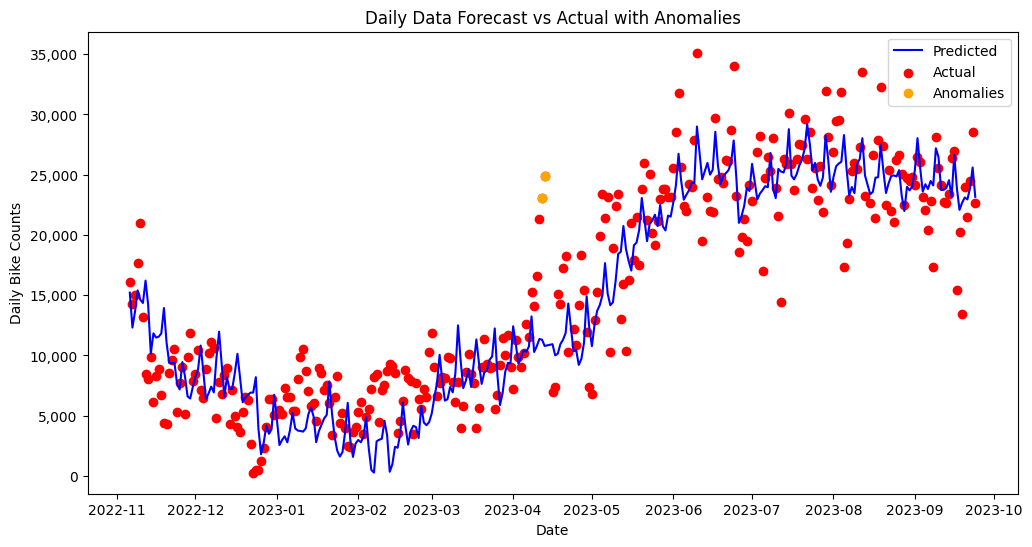

In [41]:
def format_yaxis(value, tick_number):
    return f'{int(value):,}'

plt.figure(figsize=(12, 6))
plt.plot(forecast_combined['ds'], forecast_combined['yhat'], label='Predicted', color='blue')
plt.scatter(forecast_combined['ds'], forecast_combined['y'], color='red', label='Actual')  # Using scatter for actuals
plt.scatter(anomalies_after['ds'], anomalies_after['y'], color='orange', label='Anomalies')
plt.title('Daily Data Forecast vs Actual with Anomalies')
plt.xlabel('Date')
plt.ylabel('Daily Bike Counts')
plt.legend()

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))

plt.show()

#**Prophet for hourly rides**

In [42]:
def rename_duplicate_columns(df):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols
    return df

hourly_data = rename_duplicate_columns(hourly_data)

if 'y_diff' not in hourly_data.columns:
    hourly_data['y_diff'] = hourly_data['y'].diff()


hourly_data = hourly_data.dropna(subset=['y_diff'])
hourly_data = hourly_data.drop_duplicates(subset=['ds'])
hourly_data = hourly_data.sort_values(by='ds')
hourly_data = hourly_data.copy()
hourly_data = hourly_data.rename(columns={'y_diff': 'y'})
hourly_data = hourly_data.loc[:, ~hourly_data.columns.duplicated()]

# Split the data into training and testing sets
total_records = len(hourly_data)
train_size = int(0.7 * total_records)

hourly_train = hourly_data[:train_size].copy()
hourly_test = hourly_data[train_size:].copy()

hourly_train = hourly_train.drop_duplicates(subset=['ds'])

duplicate_ds = hourly_train[hourly_train.duplicated(subset=['ds'], keep=False)]
if not duplicate_ds.empty:
    print("Found duplicate 'ds' values before final removal:")
    print(duplicate_ds)
    hourly_train = hourly_train.drop_duplicates(subset=['ds'])

duplicate_check = hourly_train[hourly_train.duplicated(subset=['ds'], keep=False)]
if not duplicate_check.empty:
    print("Remaining duplicates in 'ds' after removal:")
    print(duplicate_check)
    raise ValueError("Duplicate ds values found in the training data after removal.")

assert hourly_train['ds'].is_unique, "There are still duplicates in 'ds'"

hourly_train['ds'] = pd.to_datetime(hourly_train['ds'])
hourly_test['ds'] = pd.to_datetime(hourly_test['ds'])

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.2,
    seasonality_mode='additive'
)

model.add_seasonality(name='hourly', period=24, fourier_order=15)

try:
    model.fit(hourly_train[['ds', 'y']])
except ValueError as e:
    print("Error during model fitting:", e)
    print(hourly_train[hourly_train.duplicated(subset=['ds'], keep=False)])
    raise

future = model.make_future_dataframe(periods=len(hourly_test), freq='H')

forecast = model.predict(future)

forecast['yhat_orig'] = forecast['yhat'].cumsum() + hourly_train['y'].iloc[-1]

hourly_test = hourly_test.copy()

forecast_combined = forecast[['ds', 'yhat_orig']].merge(hourly_test[['ds', 'y']], on='ds', how='inner')

DEBUG:cmdstanpy:input tempfile: /tmp/tmptdfwjazr/wcqelkpo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdfwjazr/4pkl5dz3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37438', 'data', 'file=/tmp/tmptdfwjazr/wcqelkpo.json', 'init=/tmp/tmptdfwjazr/4pkl5dz3.json', 'output', 'file=/tmp/tmptdfwjazr/prophet_model429icwnu/prophet_model-20240525105019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:50:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:50:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [43]:
mae = mean_absolute_error(forecast_combined['y'], forecast_combined['yhat_orig'])
mse = mean_squared_error(forecast_combined['y'], forecast_combined['yhat_orig'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(forecast_combined['y'], forecast_combined['yhat_orig'])
smape_value = 100/len(forecast_combined) * np.sum(2 * np.abs(forecast_combined['yhat_orig'] - forecast_combined['y']) / (np.abs(forecast_combined['y']) + np.abs(forecast_combined['yhat_orig'])))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value}")

Mean Absolute Error (MAE): 17504512.23018074
Mean Squared Error (MSE): 310058381014978.75
Root Mean Squared Error (RMSE): 17608474.693027183
Mean Absolute Percentage Error (MAPE): 194748.32712518517
Symmetric Mean Absolute Percentage Error (SMAPE): 199.9861187293032


Prophet did very poorly with differenced hourly series, let's try non differenced data

In [44]:
def rename_duplicate_columns(df):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols
    return df


hourly_data = rename_duplicate_columns(hourly_data)
hourly_data = hourly_data.drop_duplicates(subset=['ds'])
hourly_data = hourly_data.sort_values(by='ds')
hourly_data = hourly_data.copy()

hourly_data = hourly_data.loc[:, ~hourly_data.columns.duplicated()]

total_records = len(hourly_data)
train_size = int(0.7 * total_records)

hourly_train = hourly_data[:train_size].copy()
hourly_test = hourly_data[train_size:].copy()

hourly_train = hourly_train.drop_duplicates(subset=['ds'])

duplicate_ds = hourly_train[hourly_train.duplicated(subset=['ds'], keep=False)]
if not duplicate_ds.empty:
    print("Found duplicate 'ds' values before final removal:")
    print(duplicate_ds)
    hourly_train = hourly_train.drop_duplicates(subset=['ds'])

duplicate_check = hourly_train[hourly_train.duplicated(subset=['ds'], keep=False)]
if not duplicate_check.empty:
    print("Remaining duplicates in 'ds' after removal:")
    print(duplicate_check)
    raise ValueError("Duplicate ds values found in the training data after removal.")

assert hourly_train['ds'].is_unique, "There are still duplicates in 'ds'"

hourly_train['ds'] = pd.to_datetime(hourly_train['ds'])
hourly_test['ds'] = pd.to_datetime(hourly_test['ds'])


model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.2,
    seasonality_mode='additive'
)

model.add_seasonality(name='hourly', period=24, fourier_order=15)

# Fit the model
try:
    model.fit(hourly_train[['ds', 'y']])
except ValueError as e:
    print("Error during model fitting:", e)
    print(hourly_train[hourly_train.duplicated(subset=['ds'], keep=False)])
    raise

# Make future dataframe for predictions
future = model.make_future_dataframe(periods=len(hourly_test), freq='H')

# Make predictions
forecast = model.predict(future)

# Prepare the test data for comparison
hourly_test = hourly_test.copy()

# Combine forecast with actual values for comparison
forecast_combined = forecast[['ds', 'yhat']].merge(hourly_test[['ds', 'y']], on='ds', how='inner')


DEBUG:cmdstanpy:input tempfile: /tmp/tmptdfwjazr/x1ihkpdo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdfwjazr/k8wvzei6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41665', 'data', 'file=/tmp/tmptdfwjazr/x1ihkpdo.json', 'init=/tmp/tmptdfwjazr/k8wvzei6.json', 'output', 'file=/tmp/tmptdfwjazr/prophet_model2guib4c7/prophet_model-20240525105104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:51:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:51:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [45]:
mae = mean_absolute_error(forecast_combined['y'], forecast_combined['yhat'])
mse = mean_squared_error(forecast_combined['y'], forecast_combined['yhat'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(forecast_combined['y'], forecast_combined['yhat'])
smape_value = 100/len(forecast_combined) * np.sum(2 * np.abs(forecast_combined['yhat'] - forecast_combined['y']) / (np.abs(forecast_combined['y']) + np.abs(forecast_combined['yhat'])))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value}")


Mean Absolute Error (MAE): 286.62955211715246
Mean Squared Error (MSE): 144208.41634198185
Root Mean Squared Error (RMSE): 379.74783257048597
Mean Absolute Percentage Error (MAPE): 3.330976675707354
Symmetric Mean Absolute Percentage Error (SMAPE): 79.38137323435822


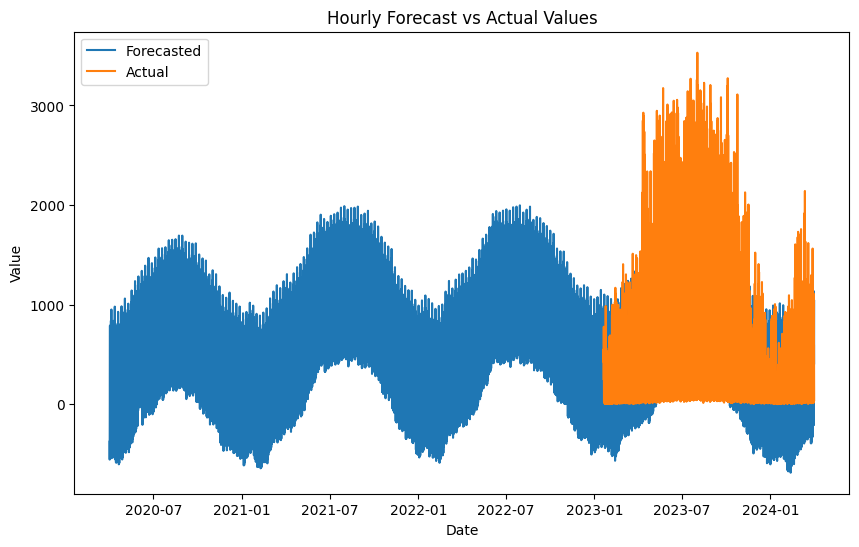

In [50]:
# Plot the forecast and actual values
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted')
plt.plot(hourly_test['ds'], hourly_test['y'], label='Actual')
plt.legend()
plt.title("Hourly Forecast vs Actual Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

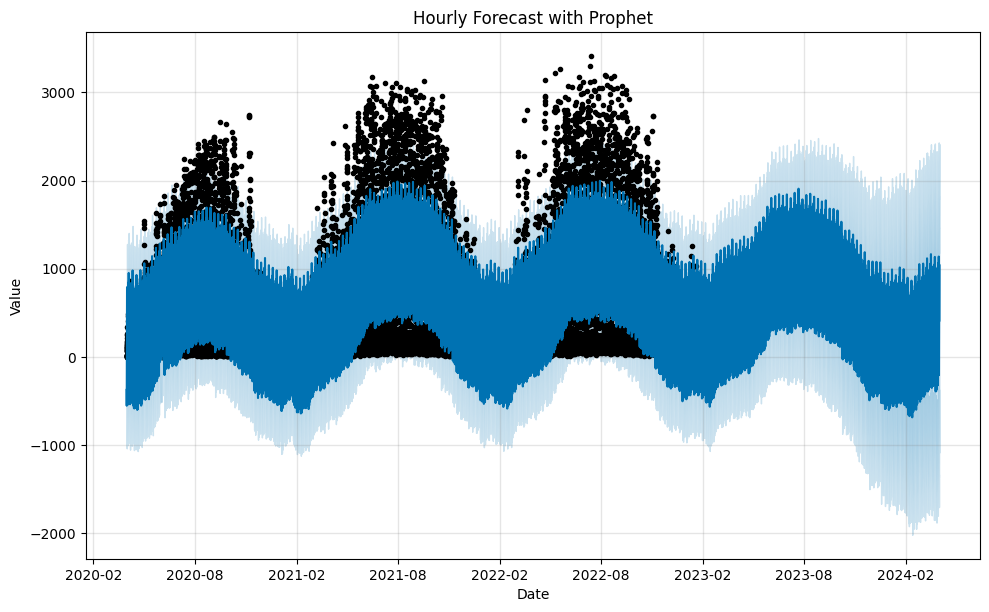

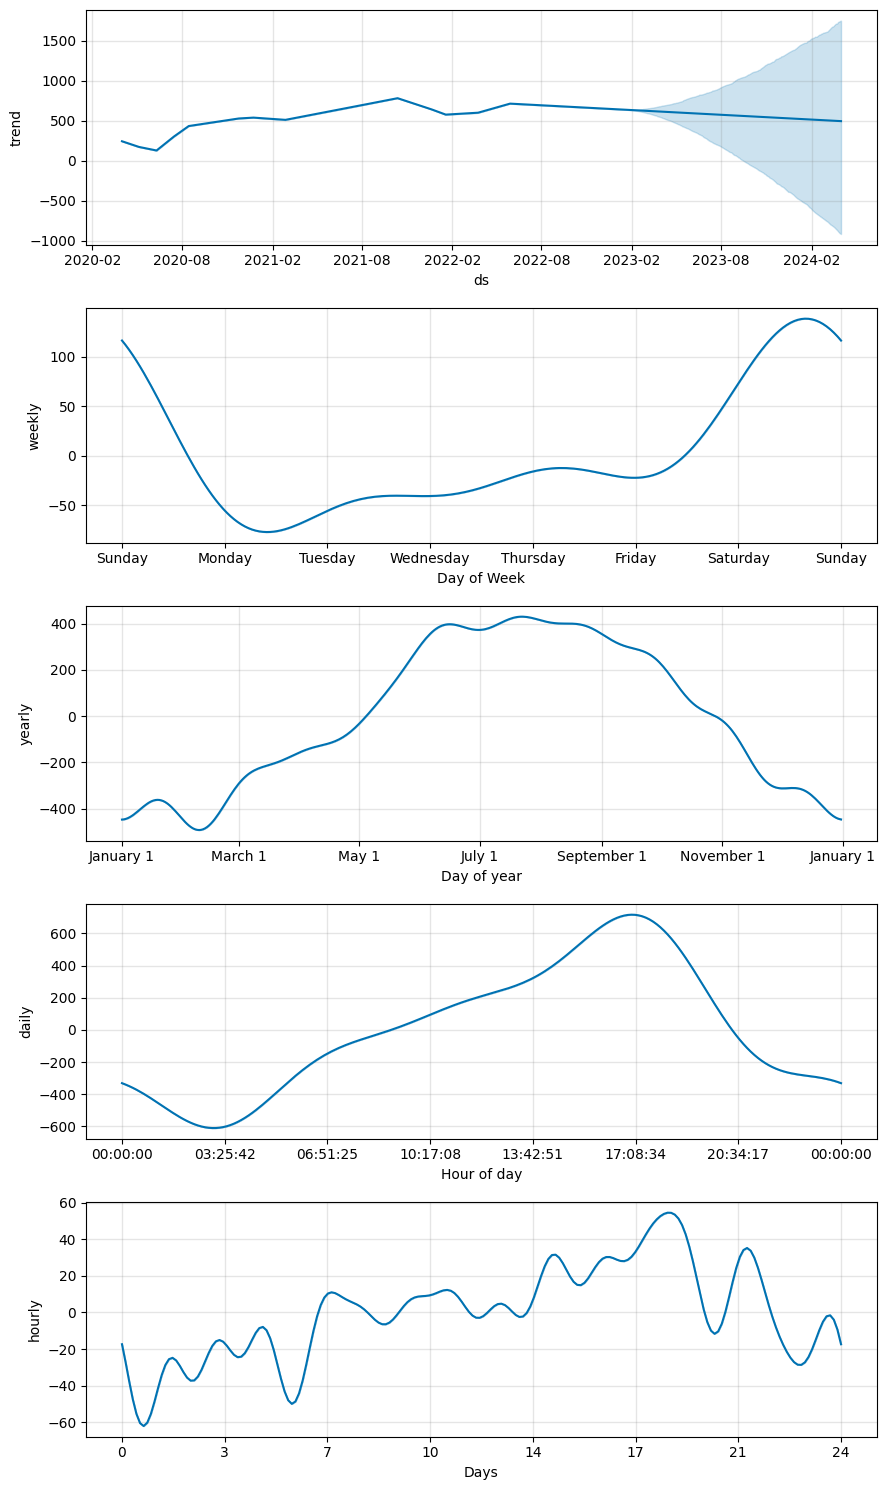

In [51]:
# Plot Prophet's forecast plot with its components
fig = model.plot(forecast)
plt.title("Hourly Forecast with Prophet")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

fig = model.plot_components(forecast)
plt.show()

The performance was a little better with non differenced data, but it's still not a good fit for this set, since the error metrics are really unaccpetably high